# Vector embedding-based change detection -- flooding

In [1]:
!pip install pystac_client==0.6.1 stackstac==0.4.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: pystac
    Found existing installation: pystac 1.6.1
    Uninstalling pystac-1.6.1:
      Successfully uninstalled pystac-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rastervision-core 0.20.3.dev0 requires pygeos==0.13, which is not installed.
rastervision-core 0.20.3.dev0 requires geopandas==0.12.0, but you have geopandas 0.13.2 which is incompatible.
rastervision-core 0.20.3.dev0 requires imageio==2.22.1, but you have imageio 2.31.1 which is incompatible.
rastervision-core 0.20.3.dev0 requires numpy==1.

---

In [1]:
import os

os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''
os.environ['AWS_SESSION_TOKEN'] = ''

In [2]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

## Get time-series of Sentinel-2 images from STAC API

Get Sentinel-2 imagery from 2023-06-01 to 2023-06-20 over Paris, France.

In [3]:
import pystac_client
import stackstac

In [4]:
bbox = Box(xmin=67.882, ymin=27.674, xmax=67.929, ymax=27.825)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [5]:
%%time

URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-2-l2a"],
    datetime="2017-01-01/2022-12-31",
    query={"eo:cloud_cover": {"lt": 5}},
).item_collection()
len(items)

CPU times: user 989 ms, sys: 64.2 ms, total: 1.05 s
Wall time: 6.62 s


388

In [6]:
stack = stackstac.stack(items)
stack

<xarray.DataArray 'stackstac-57dbe937cef718240ae57f684a4ad3c0' (time: 388,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(388, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-12...
    id                                       (time) <U24 'S2A_42RUR_20170112_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 3e+05 ... 4.098e+05
  * y                                        (y) float64 3.1e+06 ... 2.99e+06
    mgrs:grid_square                         <U2 'UR'
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32642
Attributes:
    spec:        RasterSpec(epsg=32642, bounds=(300000.0, 2990220.0, 409800.0...
    crs:         epsg:32642
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 3100020.00|\n| 0.0...
    resolution:  10.0

### Convert to a Raster Vision `RasterSource`

In [7]:
data_array = stack
data_array = data_array.sel(
    band=[
        'coastal', # B01
        'blue', # B02
        'green', # B03
        'red', # B04
        'rededge1', # B05
        'rededge2', # B06
        'rededge3', # B07
        'nir', # B08
        'nir08', # B8A
        'nir09', # B09
        'swir16', # ???
        'swir16', # B11
        'swir22', # B12
    ])

In [8]:
months = data_array['time.month']
mask = (months == 7) | (months == 8) | (months == 9) | (months == 10)
data_array = data_array.sel(time=mask)
data_array

<xarray.DataArray 'stackstac-57dbe937cef718240ae57f684a4ad3c0' (time: 113,
                                                                band: 13,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(113, 13, 10980, 10980), dtype=float64, chunksize=(1, 2, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-08-05...
    id                                       (time) <U24 'S2B_42RUR_20170805_...
  * band                                     (band) <U12 'coastal' ... 'swir22'
  * x                                        (x) float64 3e+05 ... 4.098e+05
  * y                                        (y) float64 3.1e+06 ... 2.99e+06
    mgrs:grid_square                         <U2 'UR'
    ...                                       ...
    raster:bands                             (band) object None None ... None
    gsd                                      (band) object 60 10 10 ... 20 20 20
    common_name                              (band) object 'coastal' ... 'swi...
    center_wavelength                        (band) object 0.443 0.49 ... 2.19
    full_width_half_max                      (band) object 0.027 0.098 ... 0.242
    epsg                                     int64 32642
Attributes:
    spec:        RasterSpec(epsg=32642, bounds=(300000.0, 2990220.0, 409800.0...
    crs:         epsg:32642
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 3100020.00|\n| 0.0...
    resolution:  10.0

In [9]:
valid_ts, _ = np.where(~np.isnan(data_array.isel(x=0, y=0, band=[0]).to_numpy()))
data_array = data_array.isel(time=valid_ts)
data_array

<xarray.DataArray 'stackstac-57dbe937cef718240ae57f684a4ad3c0' (time: 55,
                                                                band: 13,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(55, 13, 10980, 10980), dtype=float64, chunksize=(1, 2, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-08-05...
    id                                       (time) <U24 'S2B_42RUR_20170805_...
  * band                                     (band) <U12 'coastal' ... 'swir22'
  * x                                        (x) float64 3e+05 ... 4.098e+05
  * y                                        (y) float64 3.1e+06 ... 2.99e+06
    mgrs:grid_square                         <U2 'UR'
    ...                                       ...
    raster:bands                             (band) object None None ... None
    gsd                                      (band) object 60 10 10 ... 20 20 20
    common_name                              (band) object 'coastal' ... 'swi...
    center_wavelength                        (band) object 0.443 0.49 ... 2.19
    full_width_half_max                      (band) object 0.027 0.098 ... 0.242
    epsg                                     int64 32642
Attributes:
    spec:        RasterSpec(epsg=32642, bounds=(300000.0, 2990220.0, 409800.0...
    crs:         epsg:32642
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 3100020.00|\n| 0.0...
    resolution:  10.0

### Create the `RasterSource`

In [10]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

In [22]:
# means = np.array([756.4, 889.6, 1151.7, 1307.6, 1637.6, 2212.6, 2442.0, 2538.9, 2602.9, 2666.8, 2388.8, 2388.8, 1821.5])
# stds = np.array([1111.4, 1159.1, 1188.1, 1375.2, 1376.6, 1358.6, 1418.4, 1476.4, 1439.9, 1582.1, 1460.7, 1460.7, 1352.2])
# stats = RasterStats(means, stds)
# stats.save('SSL4EO_stats.json')

In [11]:
stats_tf = StatsTransformer.from_stats_json('SSL4EO_stats.json')

In [12]:
raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    channel_order=list(range(len(data_array.band))),
    temporal=True
)
raster_source.shape

(55, 10980, 10980, 13)

In [13]:
T = raster_source.shape[0]
t_strs = np.array([str(_t.date()) for _t in raster_source.data_array.time.to_series().to_list()])

In [64]:
window = raster_source.extent.get_windows(500, 500)[22*2 + 12]
window

Box(ymin=1000, xmin=6000, ymax=1500, xmax=6500)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [04:01<00:00,  4.39s/it]


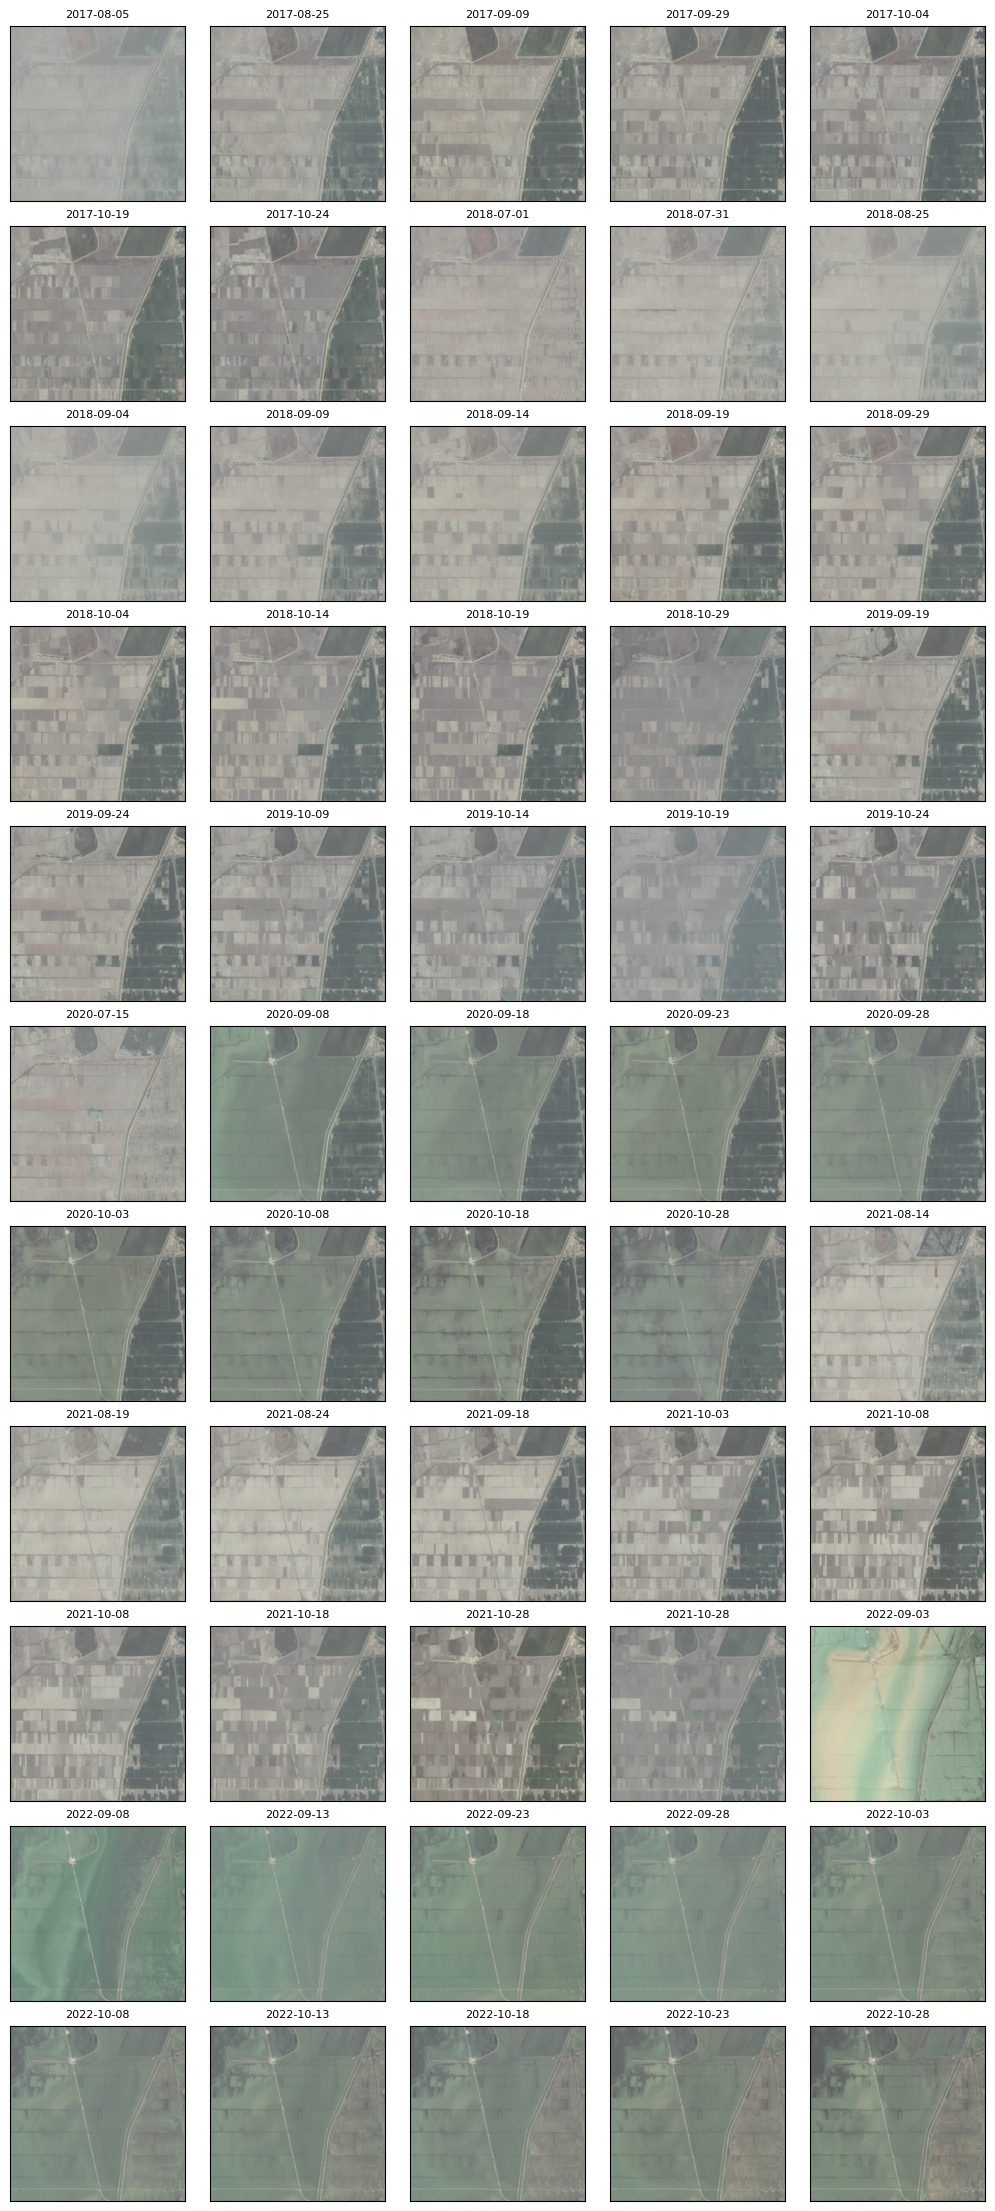

In [66]:
plt.close('all')

skip = 1
ts = range(0, T, skip)
t_strs_ = t_strs[::skip]

ncols = 5
nrows = int(math.ceil(len(ts) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)
with tqdm(zip(ts, t_strs_, axs.flat), total=len(ts)) as bar:
    for t, t_str_t, ax in bar:
        chip_t = raster_source.get_chip(window, bands=[3, 2, 1], time=t)
        ax.imshow(chip_t)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(t_str_t, fontsize=8)

if t < len(axs.flat) - 1:
    for ax in axs.flat[t + 1:]:
        ax.axis('off')
plt.show()

---

## Generate embeddings

### Get model

https://github.com/zhu-xlab/SSL4EO-S12

MoCo	ResNet18	S2-L1C 13 bands

In [14]:
from torch import nn
from torchvision.models import resnet18
from rastervision.pytorch_learner.utils import adjust_conv_channels

In [16]:
sd = torch.load('./B13_rn18_moco_0099_ckpt.pth')
sd_encoder_q = {k: v for k, v in sd['state_dict'].items() if (k.startswith('module.encoder_q') and not '.fc.' in k)}
sd_encoder_q_no_prefix = {k.replace('module.encoder_q.', ''): v for k, v in sd_encoder_q.items()}

In [18]:
model = resnet18(weights=None)
model.fc = nn.Identity()
model.conv1 = adjust_conv_channels(model.conv1, 13, pretrained=False)
model.load_state_dict(sd_encoder_q_no_prefix)
model = model.to(device=DEVICE)
model = model.eval()

---

### Run inference

In [86]:
def get_embedding(model: nn.Module, x: np.ndarray) -> np.ndarray:
    x = torch.from_numpy(x).float()
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x.to(device=DEVICE)
    out = model(x)
    out = out.cpu().numpy()
    return out

In [88]:
embeddings_train = []
embeddings_test = []

with tqdm(zip(ts, t_strs_), total=len(ts)) as bar, torch.inference_mode():
    for t, t_str in bar:
        chip_t = raster_source.get_chip(window, time=t)
        embedding_t = get_embedding(model, chip_t).squeeze()
        year, _, _ = t_str.split('-')
        year = int(year)
        if year < 2022:
            embeddings_train.append(embedding_t)
        else:
            embeddings_test.append(embedding_t)

embeddings_train = np.stack(embeddings_train)
embeddings_test = np.stack(embeddings_test)

  0%|          | 0/55 [00:00<?, ?it/s]

In [89]:
embeddings_train.shape, embeddings_test.shape

((44, 512), (11, 512))

In [91]:
embeddings_json = dict(embeddings_train=embeddings_train, embeddings_test=embeddings_test)
json_to_file(ensure_json_serializable(embeddings_json), 'flooding_embeddings.json')

---

## Analysis

In [19]:
embeddings_json = file_to_json('flooding_embeddings.json')
embeddings_train = np.array(embeddings_json['embeddings_train'])
embeddings_test = np.array(embeddings_json['embeddings_test'])

In [20]:
mu = embeddings_train.mean(axis=0)
sigma = embeddings_train.std(axis=0)

In [21]:
z_train = np.nan_to_num((embeddings_train - mu) / sigma)
z_test = np.nan_to_num((embeddings_test - mu) / sigma)
z_train = np.clip(z_train, -6, 6)
z_test = np.clip(z_test, -6, 6)

---

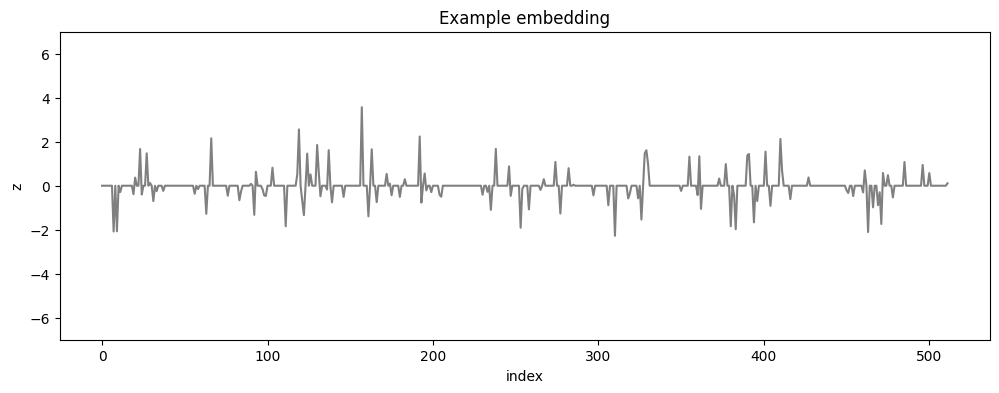

In [5]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_train:
    ax.plot(e, c='gray', alpha=1)
    break
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('Example embedding')
plt.show()

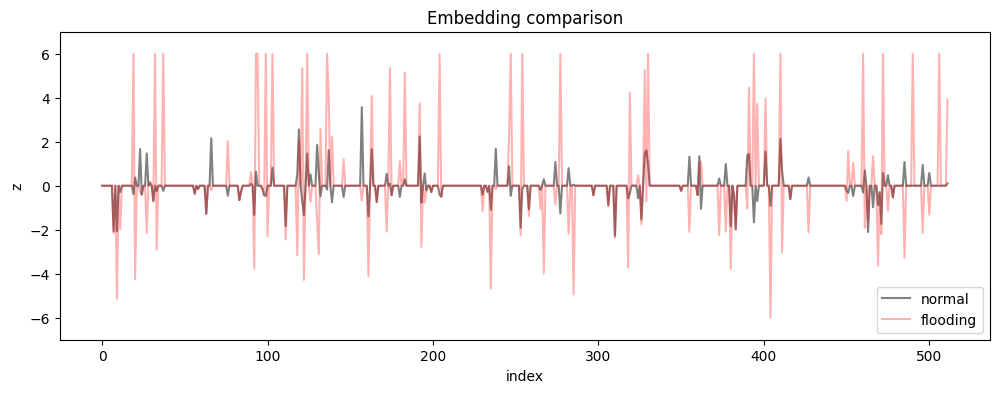

In [25]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_train:
    ax.plot(e, c='gray', alpha=1, label='normal')
    break
for e in z_test:
    ax.plot(e, c='r', alpha=.3, label='flooding')
    break
ax.legend()
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('Embedding comparison')
plt.show()

In [13]:
fig.savefig('normal_vs_flooding_embedding.png', bbox_inches='tight', pad_inches=0.2)

---

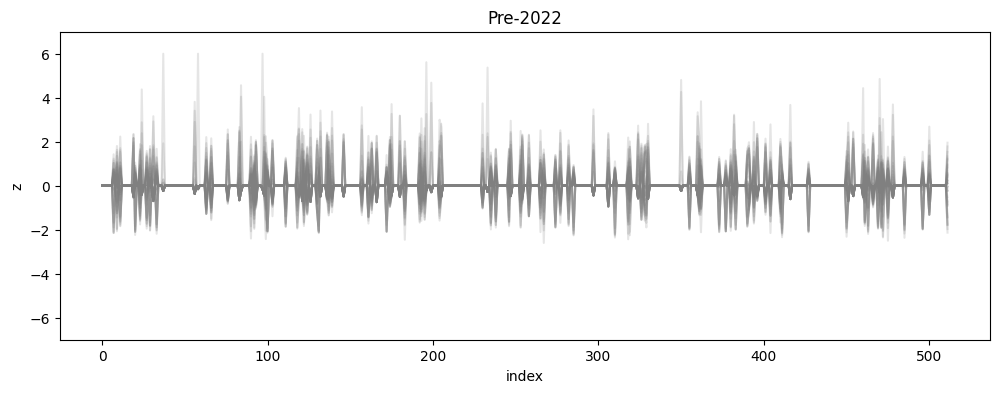

In [14]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_train:
    ax.plot(e, c='gray', alpha=0.2)
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('Pre-2022')
plt.show()

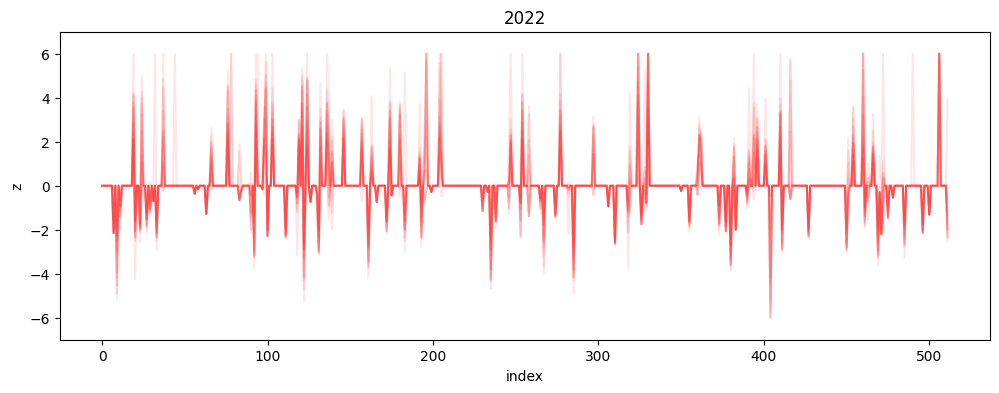

In [23]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_test:
    ax.plot(e, c='r', alpha=0.1)
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('2022')
plt.show()

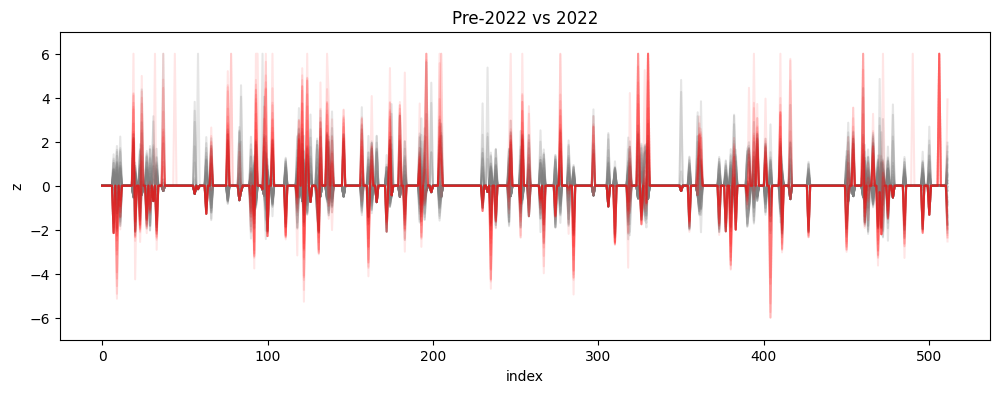

In [61]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_train:
    ax.plot(e, c='gray', alpha=0.2)
for e in z_test:
    ax.plot(e, c='r', alpha=0.1)
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('Pre-2022 vs 2022')
plt.show()

### Clustering

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne.fit(np.concatenate([embeddings_train, embeddings_test]))

TSNE()

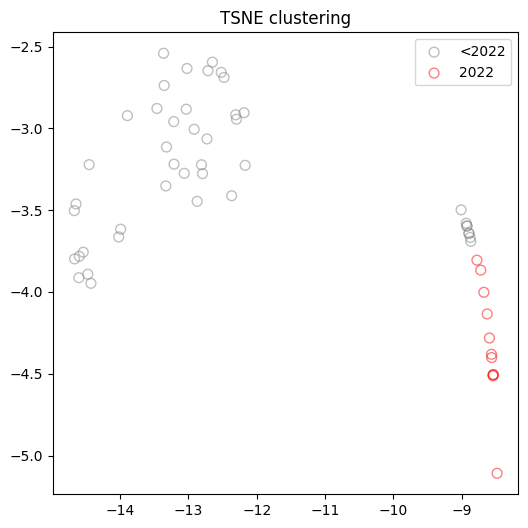

In [212]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

tsne_emb_train = tsne.embedding_[:len(embeddings_train)]
ax.scatter(tsne_emb_train[:, 0], tsne_emb_train[:, 1], s=50, ec='gray', fc='none', alpha=0.5, label='<2022')

tsne_emb_test = tsne.embedding_[len(embeddings_train):]
ax.scatter(tsne_emb_test[:, 0], tsne_emb_test[:, 1], s=50, ec='red', fc='none', alpha=0.5, label='2022')

ax.legend()
ax.set_title('TSNE clustering')

plt.show()

In [28]:
inds_2020 = np.where([s.startswith('2020-') for s in t_strs])[0]

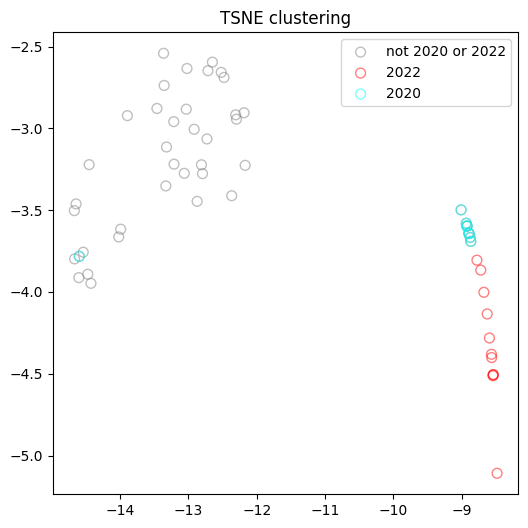

In [213]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

tsne_emb_train = tsne.embedding_[:len(embeddings_train)]
ax.scatter(tsne_emb_train[:, 0], tsne_emb_train[:, 1], s=50, ec='gray', fc='none', alpha=0.5, label='not 2020 or 2022')

tsne_emb_test = tsne.embedding_[len(embeddings_train):]
ax.scatter(tsne_emb_test[:, 0], tsne_emb_test[:, 1], s=50, ec='red', fc='none', alpha=0.5, label='2022')

tsne_emb_2020 = tsne.embedding_[inds_2020]
ax.scatter(tsne_emb_2020[:, 0], tsne_emb_2020[:, 1], s=50, ec='cyan', fc='none', alpha=0.5, label='2020')

ax.legend()
ax.set_title('TSNE clustering')

plt.show()

---

### Statistical model

#### PCA

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA()
pca.fit(z_train)

PCA()

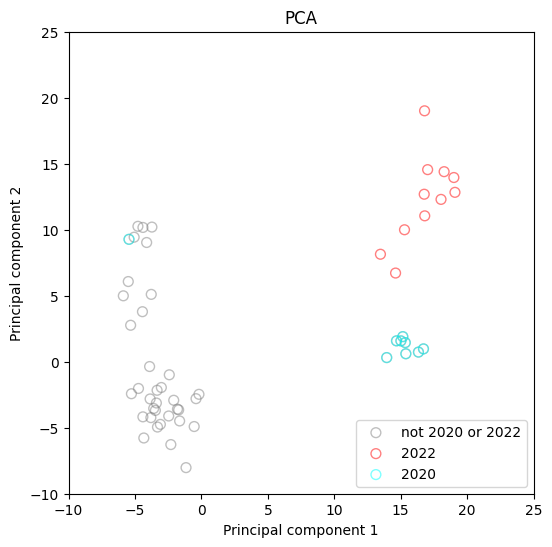

In [265]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

pca_emb_train = pca.transform(z_train)
ax.scatter(pca_emb_train[:, 0], pca_emb_train[:, 1], s=50, ec='gray', fc='none', alpha=0.5, label='not 2020 or 2022')

pca_emb_test = pca.transform(z_test)
ax.scatter(pca_emb_test[:, 0], pca_emb_test[:, 1], s=50, ec='red', fc='none', alpha=0.5, label='2022')

pca_emb_2020 = pca.transform(z_train[inds_2020])
ax.scatter(pca_emb_2020[:, 0], pca_emb_2020[:, 1], s=50, ec='cyan', fc='none', alpha=0.5, label='2020')

ax.legend(loc='lower right')
ax.set_title('PCA')
ax.set_xlim((-10, 25))
ax.set_ylim((-10, 25))
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

plt.show()

#### Gaussian Mixture Models

In [32]:
import matplotlib as mpl
from matplotlib.colors import LogNorm

def make_ellipses(gmm, ax, colors, alpha=0.2, cmap='plasma_r'):
    for n, color in enumerate(colors):
#         cov_type = gmm.covariance_type
#         if cov_type == "full":
#             covariances = gmm.covariances_[n][:2, :2]
#         elif cov_type == "tied":
#             covariances = gmm.covariances_[:2, :2]
#         elif cov_type == "diag":
#             covariances = np.diag(gmm.covariances_[n][:2])
#         elif cov_type == "spherical":
#             covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]

#         v, w = np.linalg.eigh(covariances)
#         u = w[0] / np.linalg.norm(w[0])
#         angle = np.arctan2(u[1], u[0])
#         angle = 180 * angle / np.pi  # convert to degrees
#         v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
#         ell = mpl.patches.Ellipse(
#             gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color, 
#             alpha=alpha
#         )
#         ell.set_clip_box(ax.bbox)
#         ax.add_artist(ell)
#         ax.set_aspect("equal", "datalim")
        ax.scatter(
            gmm.means_[n, 0], gmm.means_[n, 1], s=40, ec='k', fc='k', alpha=1.)
        
    # display predicted scores by the model as a contour plot
    x = np.linspace(-20.0, 30.0)
    y = np.linspace(-20.0, 40.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)

    ax.contourf(
        X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 20),
        cmap=cmap, alpha=alpha
    )
    ax.axis('tight')

In [23]:
from sklearn.mixture import GaussianMixture

In [29]:
pca_emb_train = pca.transform(z_train)
pca_emb_test = pca.transform(z_test)
pca_emb_2020 = pca.transform(z_train[inds_2020])

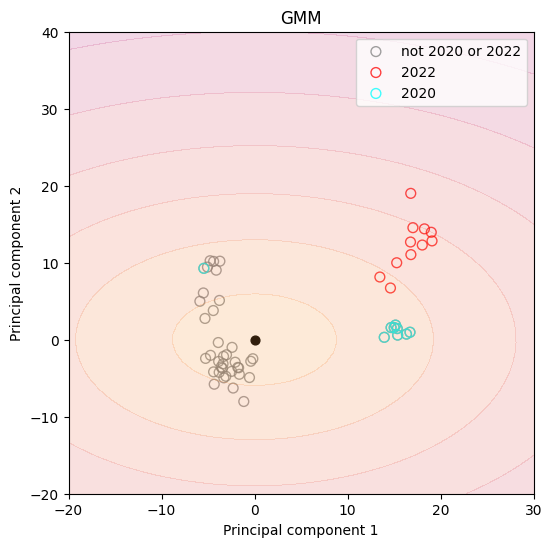

In [30]:
k = 1
gmm = GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(pca_emb_train[:, :2])

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

ax.scatter(pca_emb_train[:, 0], pca_emb_train[:, 1], s=50, ec='gray', fc='none', alpha=0.75, label='not 2020 or 2022')
ax.scatter(pca_emb_test[:, 0], pca_emb_test[:, 1], s=50, ec='red', fc='none', alpha=0.75, label='2022')
ax.scatter(pca_emb_2020[:, 0], pca_emb_2020[:, 1], s=50, ec='cyan', fc='none', alpha=0.75, label='2020')

make_ellipses(gmm, ax, colors=['gray', 'cyan', 'orange'][:k])

ax.legend()
ax.set_title('GMM')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

plt.show()

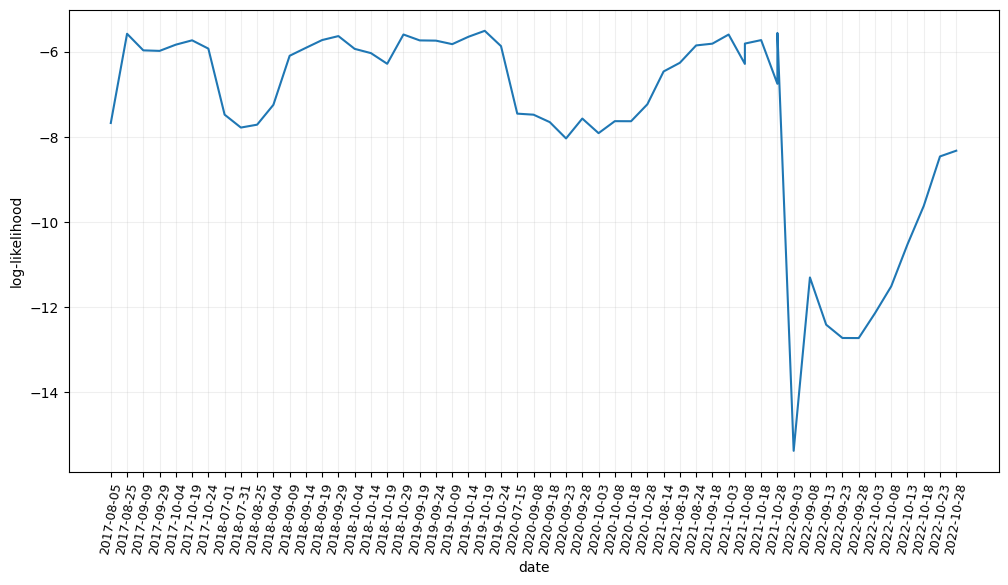

In [62]:
k = 1
gmm = GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(pca_emb_train[:, :2])

fig, ax = plt.subplots(1, 1, figsize=(12, 6), squeeze=True)
s = gmm.score_samples(np.concatenate((pca_emb_train, pca_emb_test), axis=0)[:, :2])
ax.plot(t_strs, s)
ax.xaxis.set_tick_params(rotation=80, labelsize=9)
ax.grid('k', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('log-likelihood')
plt.show()

### k = 2

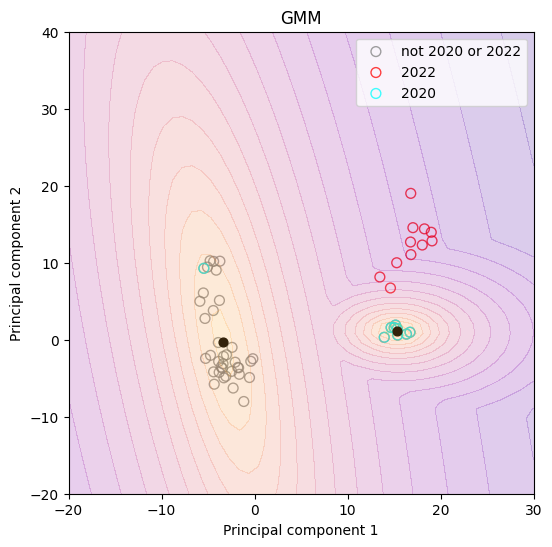

In [31]:
k = 2
gmm = GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(pca_emb_train[:, :2])

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

pca_emb_train = pca.transform(z_train)
ax.scatter(pca_emb_train[:, 0], pca_emb_train[:, 1], s=50, ec='gray', fc='none', alpha=0.75, label='not 2020 or 2022')

pca_emb_test = pca.transform(z_test)
ax.scatter(pca_emb_test[:, 0], pca_emb_test[:, 1], s=50, ec='red', fc='none', alpha=0.75, label='2022')

pca_emb_2020 = pca.transform(z_train[inds_2020])
ax.scatter(pca_emb_2020[:, 0], pca_emb_2020[:, 1], s=50, ec='cyan', fc='none', alpha=0.75, label='2020')

make_ellipses(gmm, ax, colors=['gray', 'cyan', 'orange'][:k])

ax.legend()
ax.set_title('GMM')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

plt.show()

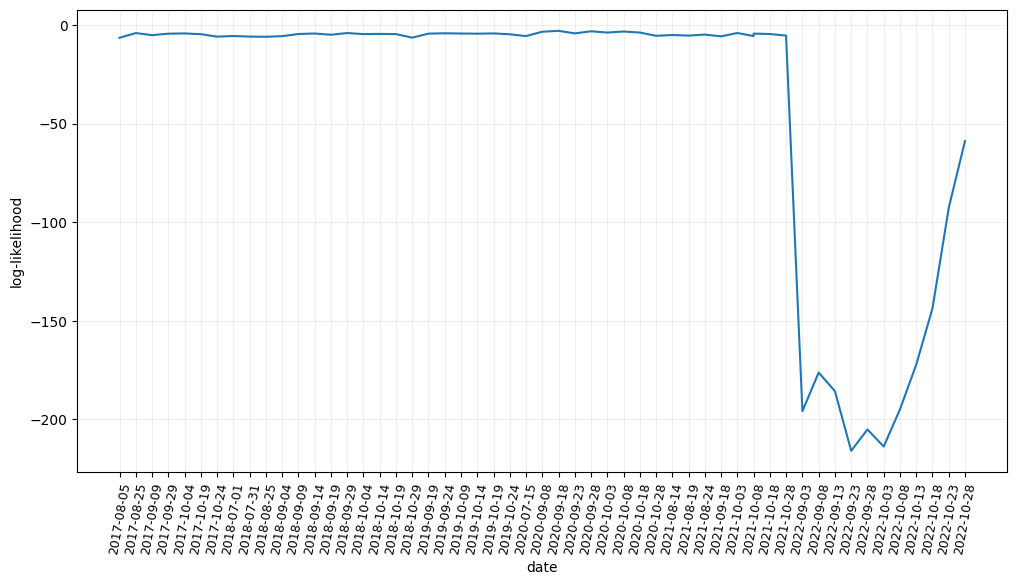

In [63]:
k = 2
gmm = GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(pca_emb_train[:, :2])

fig, ax = plt.subplots(1, 1, figsize=(12, 6), squeeze=True)
s = gmm.score_samples(np.concatenate((pca_emb_train, pca_emb_test), axis=0)[:, :2])
ax.plot(t_strs, s)
ax.xaxis.set_tick_params(rotation=80, labelsize=9)
ax.grid('k', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('log-likelihood')
plt.show()

### k = 3

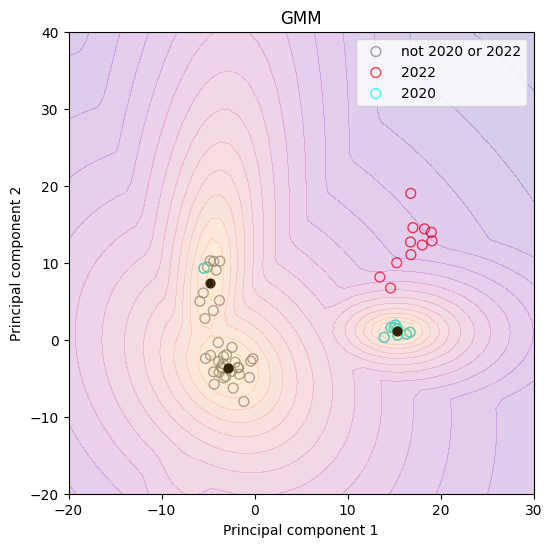

In [32]:
k = 3
gmm = GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(pca_emb_train[:, :2])

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

pca_emb_train = pca.transform(z_train)
ax.scatter(pca_emb_train[:, 0], pca_emb_train[:, 1], s=50, ec='gray', fc='none', alpha=0.75, label='not 2020 or 2022')

pca_emb_test = pca.transform(z_test)
ax.scatter(pca_emb_test[:, 0], pca_emb_test[:, 1], s=50, ec='red', fc='none', alpha=0.75, label='2022')

pca_emb_2020 = pca.transform(z_train[inds_2020])
ax.scatter(pca_emb_2020[:, 0], pca_emb_2020[:, 1], s=50, ec='cyan', fc='none', alpha=0.75, label='2020')

make_ellipses(gmm, ax, colors=['gray', 'cyan', 'orange'][:k])

ax.legend()
ax.set_title('GMM')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

plt.show()

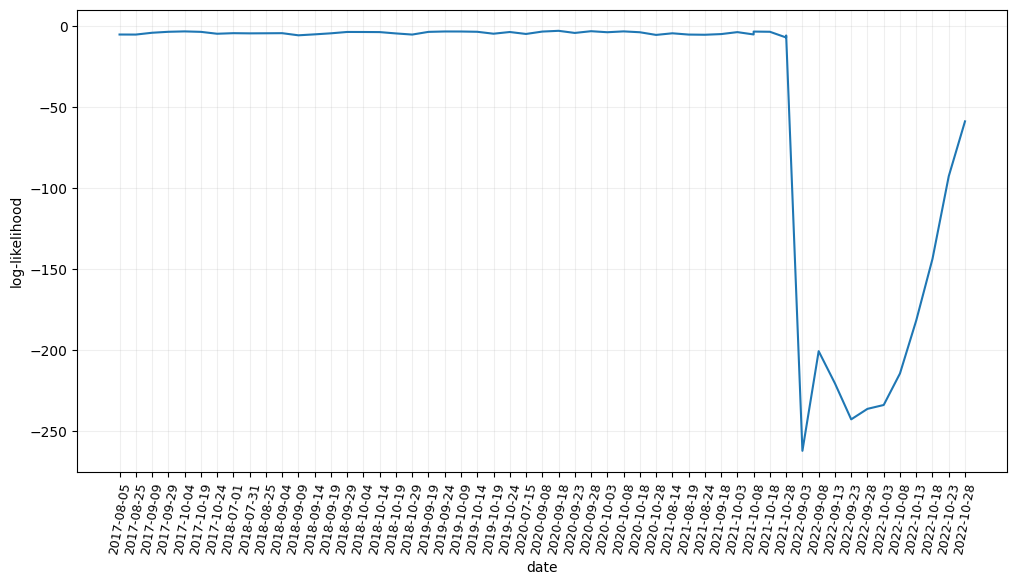

In [67]:
k = 3
gmm = GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(pca_emb_train[:, :2])

fig, ax = plt.subplots(1, 1, figsize=(12, 6), squeeze=True)
s = gmm.score_samples(np.concatenate((pca_emb_train, pca_emb_test), axis=0)[:, :2])
ax.plot(t_strs, s)
ax.xaxis.set_tick_params(rotation=80, labelsize=9)
ax.grid('k', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('log-likelihood')
# ax.set_yscale('symlog')
plt.show()

In [46]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

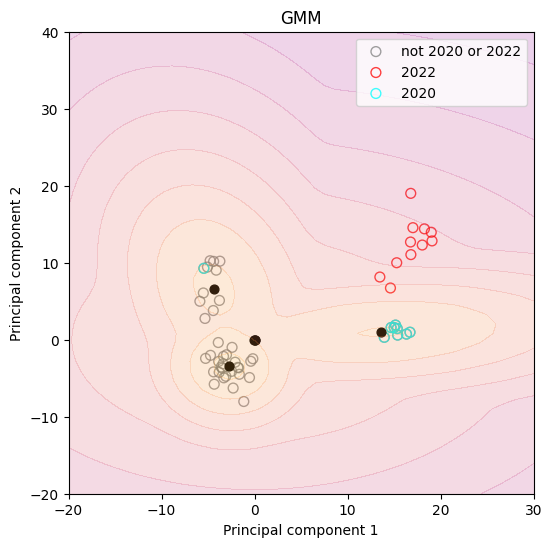

In [47]:
k = 6
gmm = BayesianGaussianMixture(n_components=k, covariance_type='full')
gmm.fit(pca_emb_train[:, :2])

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

ax.scatter(pca_emb_train[:, 0], pca_emb_train[:, 1], s=50, ec='gray', fc='none', alpha=0.75, label='not 2020 or 2022')
ax.scatter(pca_emb_test[:, 0], pca_emb_test[:, 1], s=50, ec='red', fc='none', alpha=0.75, label='2022')
ax.scatter(pca_emb_2020[:, 0], pca_emb_2020[:, 1], s=50, ec='cyan', fc='none', alpha=0.75, label='2020')

make_ellipses(gmm, ax, colors=['gray', 'cyan', 'orange', 'g', 'b', 'purple', 'brown'][:k])

ax.legend()
ax.set_title('GMM')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

plt.show()